# Siamese Network on oldsmiledata dataset

In [1]:
!nvidia-smi

Sat Nov 20 12:02:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    15W / 240W |    593MiB /  8116MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [12:02:18] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [6]:
path = Path('../dataset/oldsmiledata')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [8]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_{dataset}.csv')
valid = pd.read_csv(path/f'test_{dataset}.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        1024 non-null   object 
 1   docked                          1024 non-null   object 
 2   rmsd                            1024 non-null   float64
 3   uniprot_id                      1024 non-null   object 
 4   smiles_template                 1024 non-null   object 
 5   smiles_docked                   1024 non-null   object 
 6   mcs_smartsString                1024 non-null   object 
 7   template_HeavyAtomCount         1024 non-null   int64  
 8   template_NHOHCount              1024 non-null   int64  
 9   template_NOCount                1024 non-null   int64  
 10  template_RingCount              1024 non-null   int64  
 11  template_NumHAcceptors          1024 non-null   int64  
 12  template_NumHDonors             10

In [11]:
train.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_template_NumHDonors,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity
0,1YPJ_UIB,1K22_MEL,4.643,P00734,CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,33,3,7,...,2,3,4,7,0.165775,0.289941,1.535361,3,-0.342246,-0.100592
1,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,8,...,0,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709
2,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,6,...,0,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614
3,1C1U_BAI,5AHG_Y4L,3.943,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,CN(C)S(=O)(=O)Nc1ccc(Cl)cc1,"[#7]-,:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1",22,5,6,...,1,1,0,1,0.086957,0.106195,1.371942,3,-1.130435,-1.938053
4,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,8,...,1,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630


# Preprocessing building ImageDataGenerator

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [13]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [14]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,img_temp,img_docked,is_valid
0,2C8Y_C3M,3SHC_B01,6.732,P00734,N[C@@H](Cc1ccccc1)[C@H](O)CNS(=O)(=O)c1ccc2ccc...,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1cc(C...,[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]...,26,4,5,...,3,0.240260,0.308219,1.906872,3,0.402597,0.082192,2C8Y_C3M.png,3SHC_B01.png,True
1,2D1J_D01,1LPZ_CMB,7.109,P00742,O=C(c1cc2c(ccc[n+]2[O-])s1)N1CCN(S(=O)(=O)c2cc...,Cc1cccc2c1cc(C(=O)NCc1cc(Cl)cc(Cl)c1)n2Cc1cccc...,"[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7](:,-[#6]-[#6...",31,1,8,...,3,0.147959,0.203209,1.961362,3,-0.520408,-0.967914,2D1J_D01.png,1LPZ_CMB.png,True
2,4A7I_A7I,1NFX_RDR,7.520,P00742,CC(C)N1CCC(NS(=O)(=O)CCNC(=O)c2ccc(Cl)s2)CC1,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...,"[#6]-[#6](-,:[#6])-,:[#7](-,:[#6]-,:[#6]-,:[#6...",24,2,6,...,3,0.137143,0.177515,2.017566,3,-0.628571,-1.224852,4A7I_A7I.png,1NFX_RDR.png,True
3,1ZGV_501,1C5O_BAM,3.197,P00734,CCCCNc1cc(C)nc2nc(Nc3cc(Cl)ccc3C)nn12,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-,:[#6](:[#6]:[#6]:[#6]:[#6]):,-[#6]",24,2,6,...,1,0.064815,0.127451,1.162213,3,-1.351852,-1.725490,1ZGV_501.png,1C5O_BAM.png,True
4,3DA6_BZ9,4W4V_3H8,11.188,P53779,CNc1nccc(-c2cccnc2Oc2c(C)cc(Nc3nc4ccccc4[nH]3)...,Cc1cc(NC(=O)c2cccc(-n3cc(NC(=O)Nc4ccccc4Cl)cn3...,"[#7]:[#6]:[#6](-,:[#7]-,:[#6]-[#7]-[#6]1:[#6]:...",36,3,8,...,2,0.190698,0.213270,2.414842,3,-0.093023,-0.867299,3DA6_BZ9.png,4W4V_3H8.png,True


In [15]:
target_shape=(224, 224)

In [16]:
IMAGES = '../dataset/oldsmiledata/mol_images/all/'

In [17]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_jpeg(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [71]:
def preprocess_triplets(tup, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(tup[0]),
        preprocess_image(tup[1]),
        preprocess_image(negative),
    )

In [20]:
image = preprocess_image('/4A7I_A7I.png')
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

In [21]:
train_template_images = [r.img_temp for i, r in train.iterrows()]

In [22]:
train_docked_images = [r.img_docked for i, r in train.iterrows()]

In [23]:
len(train_template_images), len(train_docked_images)

(23924, 23924)

In [35]:
valid_template_images = [r.img_temp for i, r in valid.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid.iterrows()]

In [25]:
negative_images = train_template_images + train_docked_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [36]:
val_negative_images = valid_template_images + valid_docked_images
np.random.RandomState(seed=32).shuffle(negative_images)

val_negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
val_negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [37]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

24948

In [38]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [39]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [40]:
y_train = train['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))


In [41]:
y_valid = valid['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

In [67]:
train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset))
train_dataset = tf.data.Dataset.zip((train_dataset, negative_dataset))
valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset))
valid_dataset = tf.data.Dataset.zip((valid_dataset, val_negative_dataset))
train_dataset, valid_dataset

(<ZipDataset shapes: (((), ()), ()), types: ((tf.string, tf.string), tf.string)>,
 <ZipDataset shapes: (((), ()), ()), types: ((tf.string, tf.string), tf.string)>)

In [72]:
train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = valid_dataset.map(preprocess_triplets)
train_dataset, val_dataset

(<MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>,
 <MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>)

In [73]:
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(8)
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>

In [74]:
val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)
val_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>

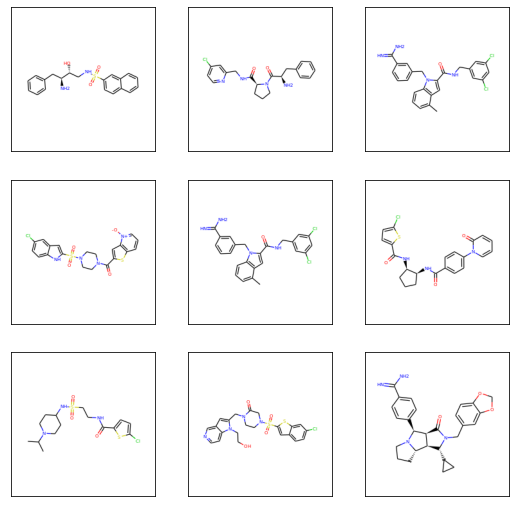

In [75]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(val_dataset.take(1).as_numpy_iterator())[0])


# Create Siamese net with keras

In [80]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape +  (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [81]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [82]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [83]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)


ValueError: in converted code:

    <ipython-input-78-6581cf0f6e0b>:18 call  *
        return self.siamese_network(inputs)
    /home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:737 __call__
        self.name)
    /home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/input_spec.py:155 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_3 expects 3 inputs, but it received 1 input tensors. Inputs received: [<tf.Tensor 'input_1_4:0' shape=(None, 224, 224, 3) dtype=float32>]
